In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
## Load previous results of tanimoto similarities and simba results
## based on the tanimoto similarities, retrieve the spectra that corresponds to the best candidate for each query
## find if the best candidate is in the 10 first matches

In [38]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [39]:
import dill
from src.preprocessor import Preprocessor
from src.load_data import LoadData
from src.config import Config
from rdkit import Chem
import numpy as np

## Parameters

In [40]:
data_folder= '/Users/sebas/projects/data/'
dataset_path= data_folder +'edit_distance_neurips_nist_exhaustive.pkl'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
casmi_file= data_folder + 'processed_massformer/spec_df.pkl' 
USE_CASMI=True
USE_MCES_RAW=False

In [101]:
similarities_files= [
#'simba_EDIT_DISTANCE_MCES20_NEURIPS_20241115',
#'simba_EDIT_DISTANCE_MCES20_NEURIPS_precursor_randomized',
    'modified_cosine_casmi_NEURIPS',
    'ms2deepscore_v2_casmi_NEURIPS',
    'simba_modcos',
    #'simba_generated_data_20250126',
    'simba_generated_data_20250130',
'spec2vec_casmi_NEURIPS',
                    ]

#model_results_path='simba_EDIT_DISTANCE_MCES20_NEURIPS'
#model_results_path='spec2vec_casmi_NEURIPS'
#model_results_path='ms2deepscore_casmi_NEURIPS'

In [42]:
tanimoto_results_path = 'tanimoto_similarity_casmi_NEURIPS'

In [43]:
format_file_unknown = "./notebooks/discovery_search/results/{}_results_analog_discovery_unknwon_compounds.pkl"

In [44]:
config=Config()

## Load reference dataset

In [45]:
pp=Preprocessor()


In [46]:
with open(dataset_path, 'rb') as file:
            dataset = dill.load(file)

In [47]:
all_spectrums_reference_original= dataset['molecule_pairs_train'].spectrums_original +\
                    dataset['molecule_pairs_val'].spectrums_original + \
                        dataset['molecule_pairs_test'].spectrums_original

In [48]:
import copy
all_spectrums_reference_processed= [copy.deepcopy(s) for s in all_spectrums_reference_original]

In [49]:
all_spectrums_reference_processed = [pp.preprocess_spectrum(
            s,
            fragment_tol_mass=10,
            fragment_tol_mode="ppm",
            min_intensity=0.01,
            max_num_peaks=100,
            scale_intensity=None,
        ) for s in all_spectrums_reference_processed]
    
all_spectrums_reference = [s_original for s_original, s_processed in zip(all_spectrums_reference_original,all_spectrums_reference_processed) if len(s_processed.mz)>=6]

## Load query spectra

In [50]:
if USE_CASMI:
    all_spectrums_janssen_original=LoadData.get_all_spectrums_casmi(
        casmi_file,
        config=config,
    )
else:
    loader_saver = LoaderSaver(
            block_size=100,
            pickle_nist_path='',
            pickle_gnps_path='',
            pickle_janssen_path=output_janssen_file,
        )
    all_spectrums_janssen_original = loader_saver.get_all_spectrums(
                janssen_path,
                100000000,
                use_tqdm=True,
                use_nist=False,
                config=config,
                use_janssen=True,
            )

In [51]:
all_spectrums_janssen_processed= [copy.deepcopy(s) for s in all_spectrums_janssen_original]

In [52]:
pp=Preprocessor()
### remove extra peaks in janssen
all_spectrums_janssen_processed = [pp.preprocess_spectrum(
            s,
            fragment_tol_mass=10,
            fragment_tol_mode="ppm",
            min_intensity=0.01,
            max_num_peaks=100,
            scale_intensity=None,
        ) for s in all_spectrums_janssen_processed]

all_spectrums_janssen = [s_original for s_original, s_processed in zip(all_spectrums_janssen_original,all_spectrums_janssen_processed) if len(s_processed.mz)>=6]

## Get only the spectra that is not present

In [53]:
canon_smiles_reference = [Chem.CanonSmiles(s.smiles) for s in all_spectrums_reference]
canon_smiles_janssen =   [Chem.CanonSmiles(s.smiles) for s in all_spectrums_janssen]
janssen_indexes_in_ref= [i for i,s in enumerate(canon_smiles_janssen) if s in canon_smiles_reference]
janssen_indexes_not_in_ref = [i for i,s in enumerate(canon_smiles_janssen) if s not in canon_smiles_reference]

In [54]:
len(janssen_indexes_in_ref),len(janssen_indexes_not_in_ref)

(26, 132)

In [55]:
all_spectrums_janssen = [all_spectrums_janssen[index] for index in janssen_indexes_not_in_ref]

## Load similarity results

## Load results for simba and spec2vec

In [102]:
model_results = {}
for sim in similarities_files:
    with open(format_file_unknown.format(sim), 'rb') as f:
                model_results[sim]= dill.load(f)

In [57]:
with open(format_file_unknown.format(tanimoto_results_path), 'rb') as f:
                tanimoto_results= dill.load(f)

In [58]:
golden_truth=tanimoto_results['similarities']

In [59]:
!pip install myopic-mces

In [60]:
from src.analog_discovery.performance_analysis import PerformanceAnalysis

In [61]:
import matplotlib.pyplot as plt

In [62]:
golden_truth.shape

(132, 328555)

In [103]:
accuracy_results={}
min_tanimotos= [0, 0.25, 0.5, 0.75, 0.90]
k_list=[10,100, 500, 1000]

#min_tanimotos= [0,0.90]
#k_list=[10,1000]

accuracy_results = {k:{} for k in min_tanimotos}

for sim in model_results:
#for sim in ['simba_modcos']:   
    results_temp = PerformanceAnalysis.obtain_precision_k_candidates(golden_truth=golden_truth, 
                          predicted=model_results[sim]['similarities'], 
                          smiles_reference=model_results[sim]['smiles_reference'],
                           smiles_janssen=model_results[sim]['smiles_janssen'],
                          all_spectrums_reference=all_spectrums_reference, 
                           all_spectrums_janssen=all_spectrums_janssen,
                            min_tanimotos= min_tanimotos,
                            k_list=k_list,)
    for k in min_tanimotos:
        accuracy_results[k][sim] = results_temp[k]

Size of predictions: (132, 328555)
Size of predictions: (132, 328555)
Size of predictions: (132, 328555)
Size of predictions: (132, 328555)
Size of predictions: (132, 328555)
Size of predictions: (132, 328554)
Size of predictions: (132, 328554)
Size of predictions: (132, 328554)
Size of predictions: (132, 328554)
Size of predictions: (132, 328554)
Size of predictions: (132, 328555)
Size of predictions: (132, 328555)
Size of predictions: (132, 328555)
Size of predictions: (132, 328555)
Size of predictions: (132, 328555)
Size of predictions: (132, 328555)
Size of predictions: (132, 328555)
Size of predictions: (132, 328555)
Size of predictions: (132, 328555)
Size of predictions: (132, 328555)
Size of predictions: (132, 328534)
Size of predictions: (132, 328534)
Size of predictions: (132, 328534)
Size of predictions: (132, 328534)
Size of predictions: (132, 328534)


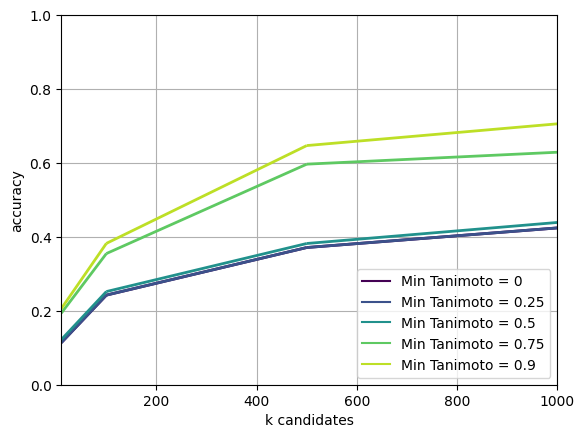

In [64]:
from matplotlib.collections import LineCollection

sim = 'simba_generated_data_20250130'
fig, ax = plt.subplots()
for min_tanimoto in min_tanimotos:
    x= np.array(k_list)
    y=np.array(accuracy_results[min_tanimoto][sim]) 
    
    min_tanimoto_vector = [min_tanimoto for s in y]
    # Prepare the points for the line segments
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    
    norm = plt.Normalize(0, 1.0)
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(min_tanimoto_vector)  # The value determining color
    lc.set_linewidth(2)
    
    # Create the plot
    
    ax.add_collection(lc)
    
    # Add markers at each point
    #ax.plot(x, y, '*', color='black', markersize=5)  # Adds '*' markers
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())

    # Annotate the line with its min_tanimoto value near the last point
    # Add a proxy line for the legend
    ax.plot([], [], label=f'Min Tanimoto = {min_tanimoto}', color=plt.cm.viridis(norm(min_tanimoto)))
    
#plt.colorbar(lc, ax=ax, label='min tanimoto')
plt.ylim([0,1])
plt.grid()
plt.xlabel('k candidates')
plt.ylabel('accuracy')
plt.legend(loc='lower right')

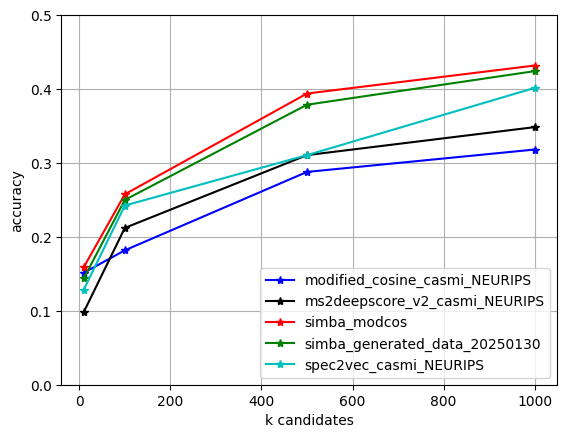

In [105]:
import matplotlib.pyplot as plt
colors=['b','k','r', 'g','c']

min_tanimoto=0.00
#plt.figure(figsize=(10,5))
for sim,c in zip(similarities_files, colors):
        plt.plot(k_list, accuracy_results[min_tanimoto][sim], marker="*", color=c, label=sim)


plt.xlabel('k candidates')
#plt.ylim([0.00,0.42])
plt.ylim([0.00,0.5])
#plt.xscale('log')
plt.legend(loc= "lower right")
plt.ylabel('accuracy')
plt.grid()

In [67]:
import matplotlib.pyplot as plt
colors=['b','k','r', 'g']

min_tanimoto=0.00
#plt.figure(figsize=(10,5))
for sim,c in zip(similarities_files, colors):
        plt.plot(k_list, accuracy_results[min_tanimoto][sim], marker="*", color=c, label=sim)


plt.xlabel('k candidates')
#plt.ylim([0.00,0.42])
plt.ylim([0.00,0.5])
#plt.xscale('log')
plt.legend(loc= "lower right")
plt.ylabel('accuracy')
plt.grid()

KeyError: 'modified_cosine_casmi_NEURIPS'

## Let's compare predictions for simba and spec2vec

In [31]:
target_indexes_list=np.arange(0,len(all_spectrums_janssen))
K=10

In [32]:
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from src.tanimoto import Tanimoto
from src.mces.mces_computation import MCES

In [33]:
from src.analog_discovery.performance_analysis import PerformanceAnalysis

In [34]:
folder_path = data_folder + "comparison_simba_spec2vec_precursor_randomized/"

Running myopic ...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/4afe2ccf7ed241c1ae37beddc156cd6e-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/4afe2ccf7ed241c1ae37beddc156cd6e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5504 COLUMNS
At line 31199 RHS
At line 36699 BOUNDS
At line 39677 ENDATA
Problem MODEL has 5499 rows, 2977 columns and 18972 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 6 - 0.31 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 202 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 202 strengthened rows, 0 substitutions
Cgl0004I processed model has 3049 rows, 2948 columns (2948 

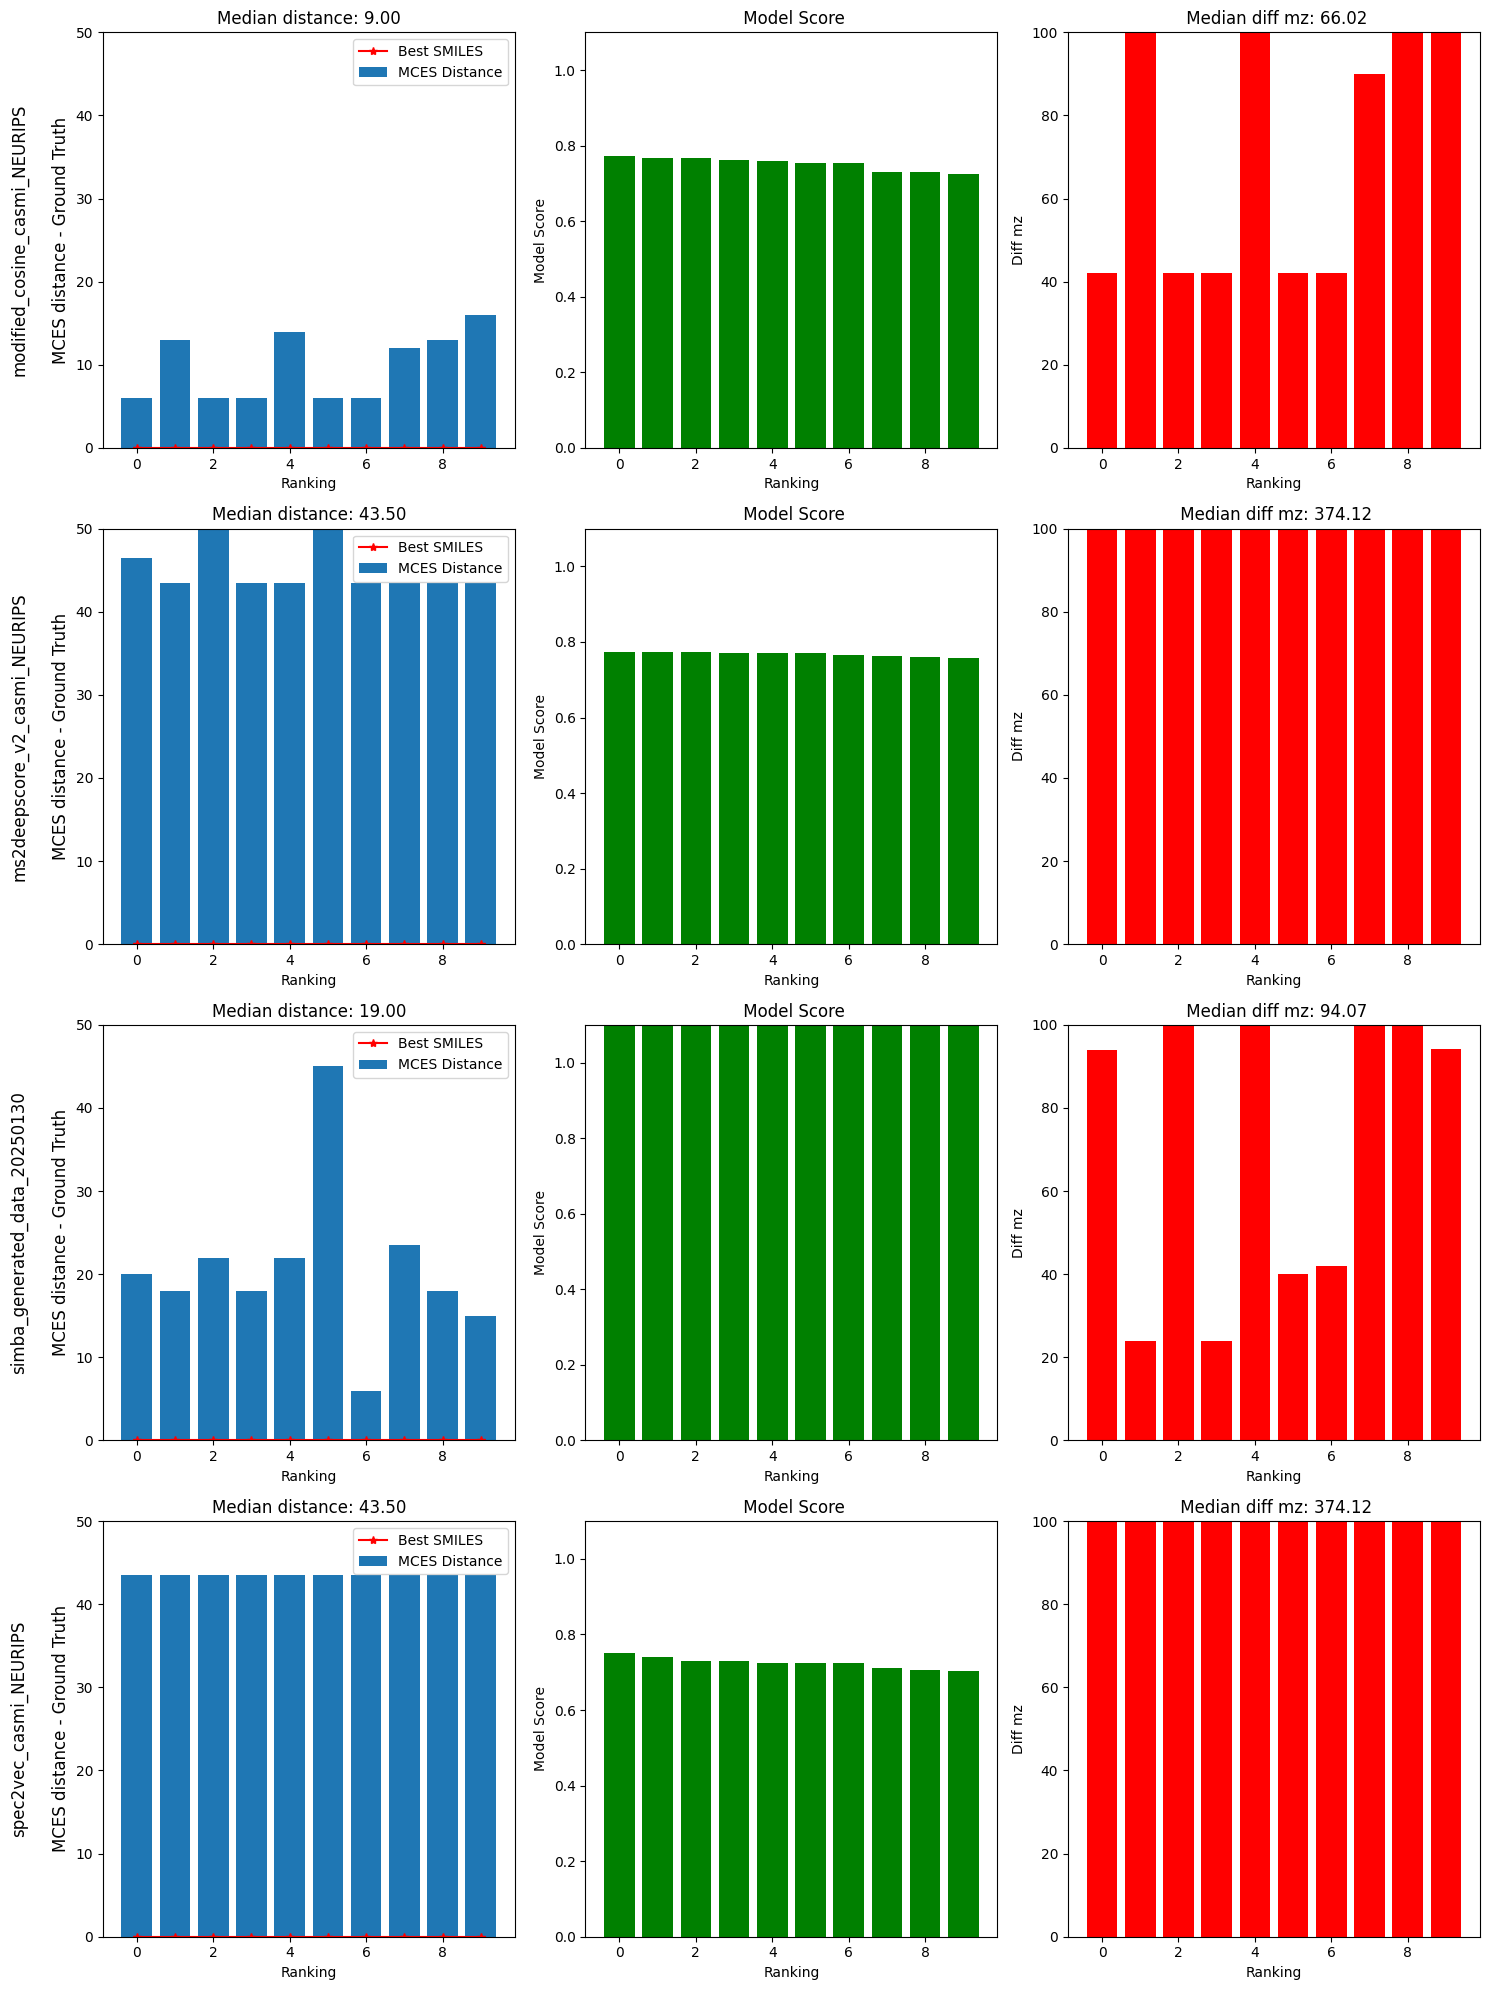

Running myopic ...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/2dd8460c636b45799b01fddee107ff53-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/2dd8460c636b45799b01fddee107ff53-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2962 COLUMNS
At line 15589 RHS
At line 18547 BOUNDS
At line 20029 ENDATA
Problem MODEL has 2957 rows, 1481 columns and 9294 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2 - 0.02 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 82 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 82 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 8 strengthened rows, 0 s

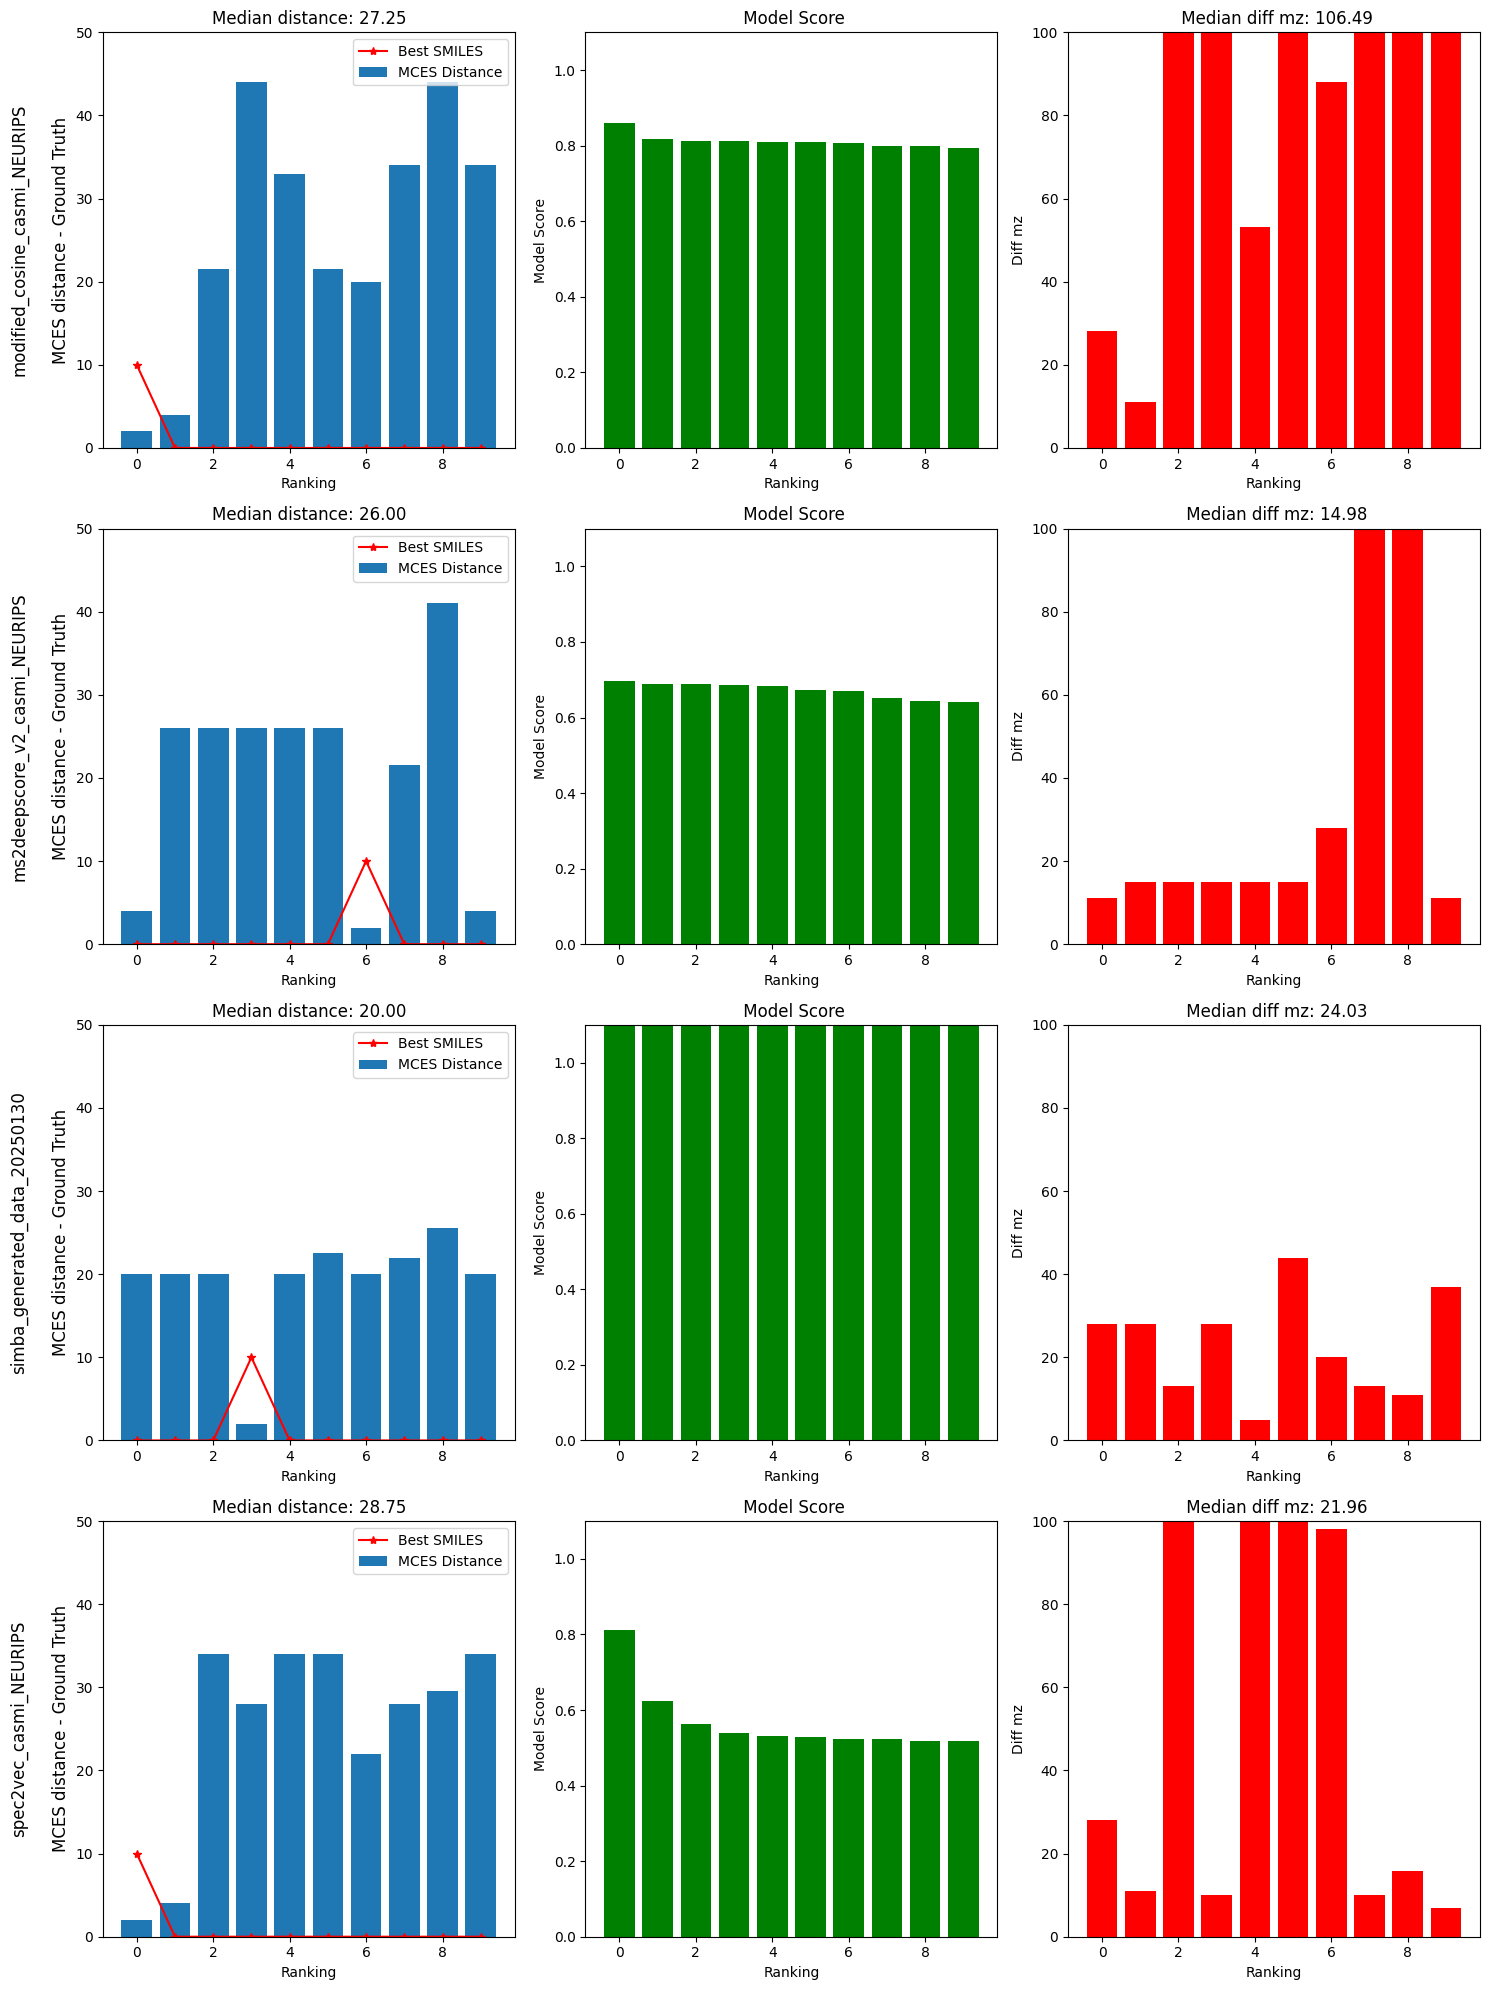

Running myopic ...
Finished myopic
reading csv
Running myopic ...
Finished myopic
reading csv
Running myopic ...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/bcf26ca34b094945bd08a80f0e30c576-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/bcf26ca34b094945bd08a80f0e30c576-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4804 COLUMNS
At line 23797 RHS
At line 28597 BOUNDS
At line 30854 ENDATA
Problem MODEL has 4799 rows, 2256 columns and 14004 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 116 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 116 

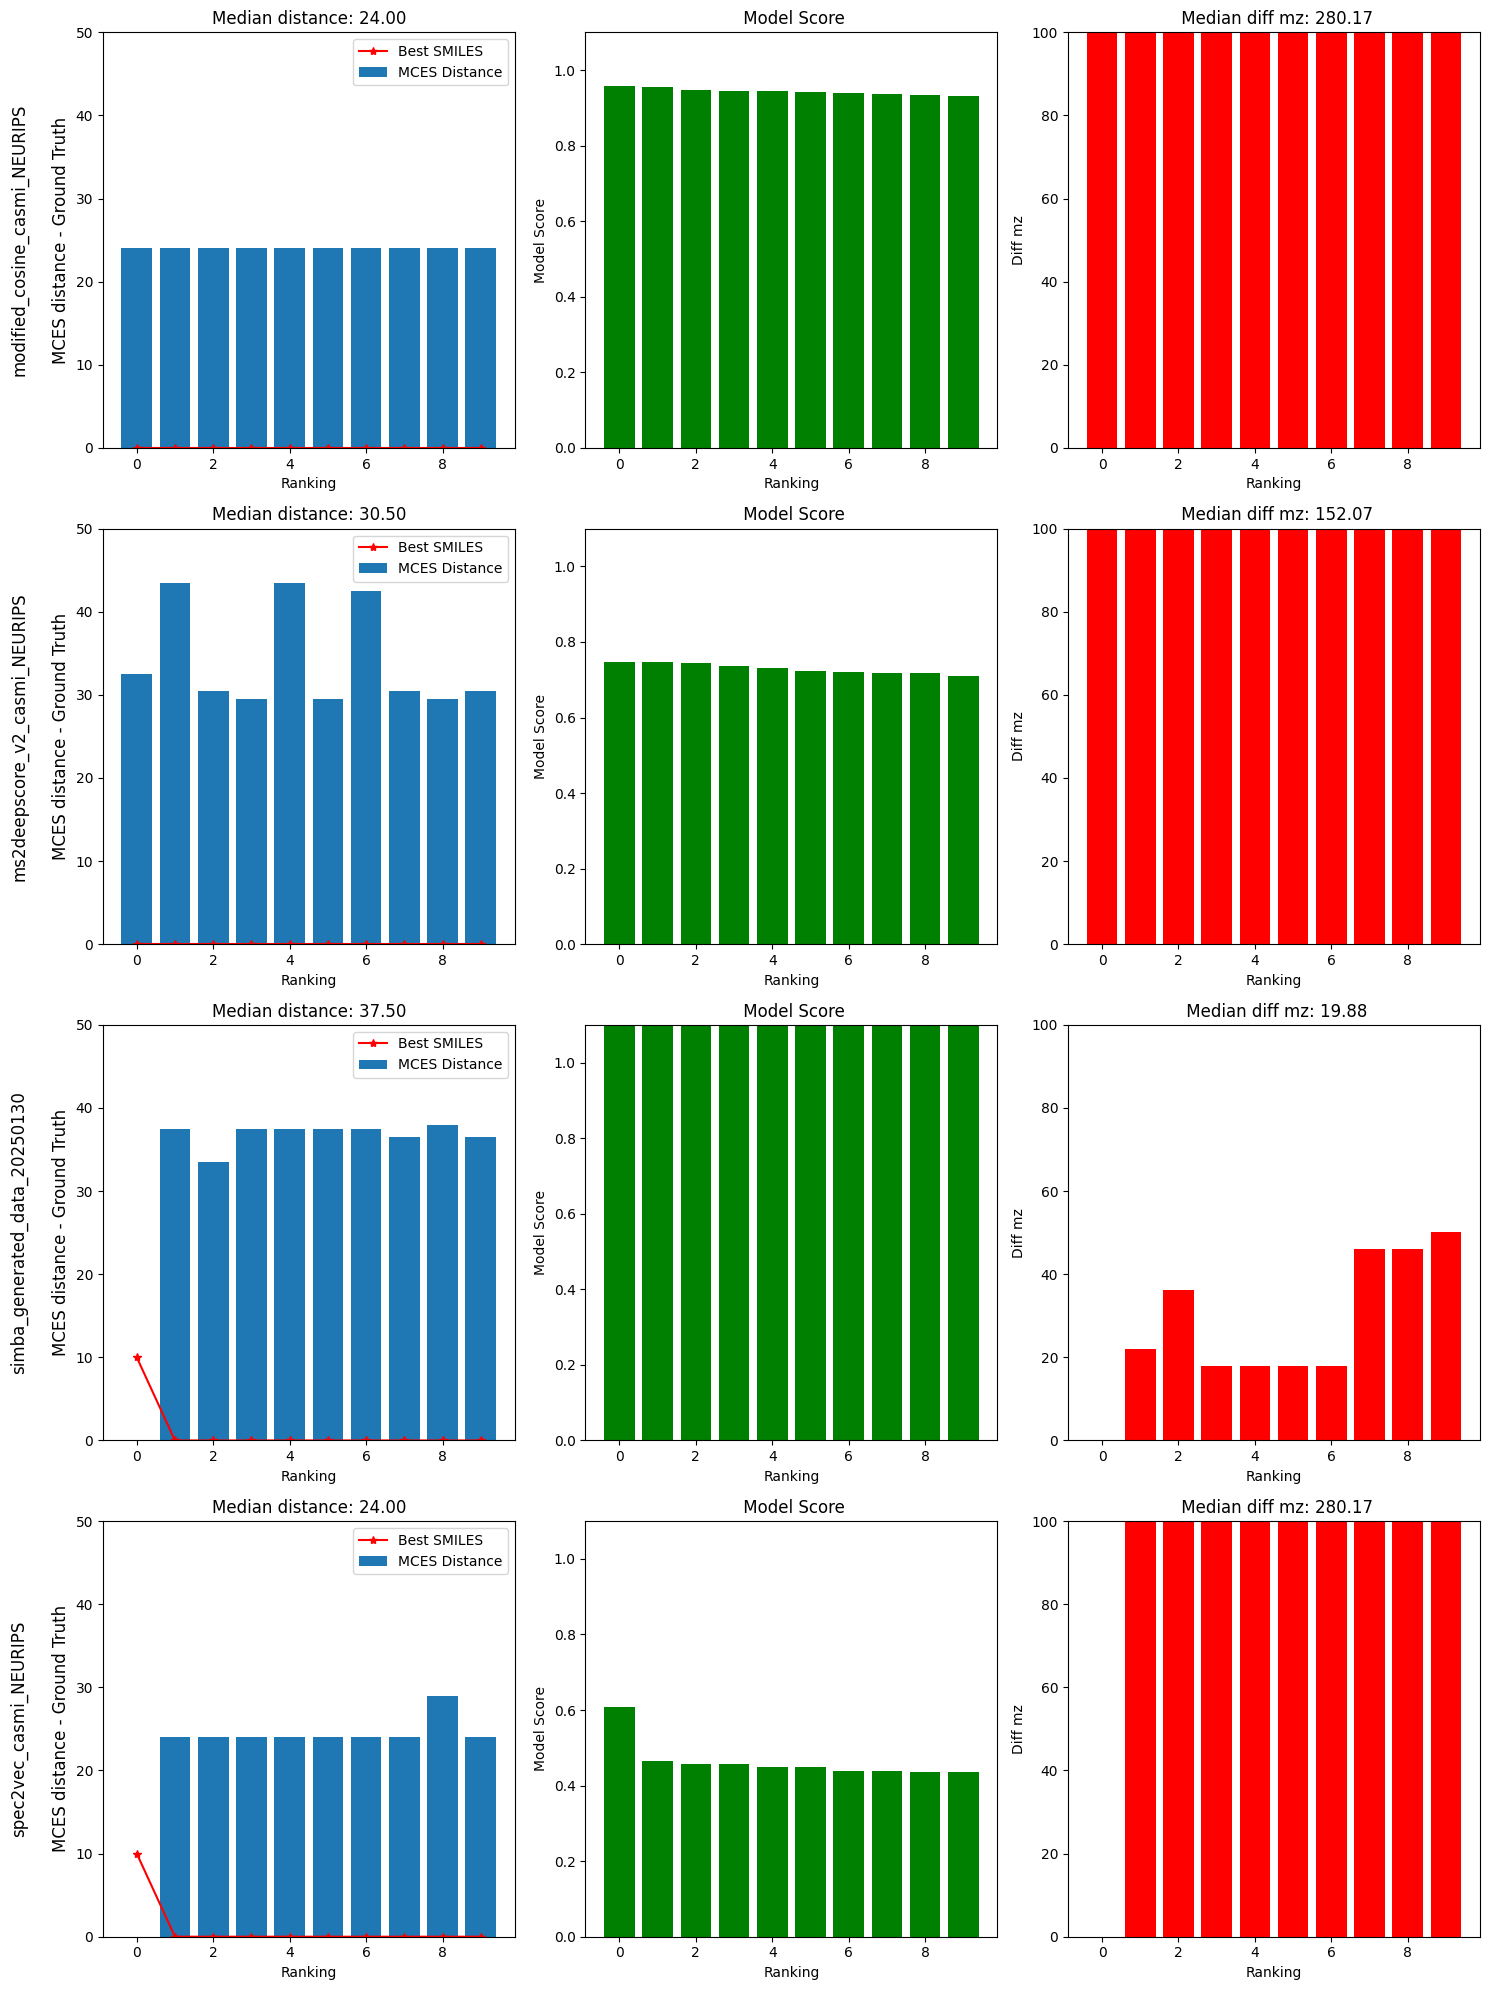

Running myopic ...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/ab296d33f9854465b9f30f5c1fcca72a-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/ab296d33f9854465b9f30f5c1fcca72a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 3116 COLUMNS
At line 21596 RHS
At line 24708 BOUNDS
At line 26930 ENDATA
Problem MODEL has 3111 rows, 2221 columns and 13872 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1 - 0.23 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 10 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 10 strengthened rows, 0 substitutions
Cgl0004I processed model has 2269 rows, 2221 columns (2221 in

Traceback (most recent call last):
  File "/Users/sebas/miniconda3/envs/transformers/bin/myopic_mces", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/myopic_mces/myopic_mces.py", line 125, in main
    results = [MCES(i[0], i[1], i[2], threshold, solver, **additional_mces_options) for i in inputs]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/myopic_mces/myopic_mces.py", line 125, in <listcomp>
    results = [MCES(i[0], i[1], i[2], threshold, solver, **additional_mces_options) for i in inputs]
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/myopic_mces/myopic_mces.py", line 71, in MCES
    res = MCES_ILP(G1, G2, threshold, solver, solver_options=solve

Error in callback <function _draw_all_if_interactive at 0x28e32ae80> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x2ef9b7920> (for post_execute), with arguments args (),kwargs {}:


Exception ignored in: <function _on_type_disposal at 0x1294bc680>
Traceback (most recent call last):
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/numba/core/types/abstract.py", line 28, in _on_type_disposal
    def _on_type_disposal(wr, _pop=_typecache.pop):
    
KeyboardInterrupt: 

KeyboardInterrupt



In [35]:
PerformanceAnalysis.plot_performance(model_results, 
                                    target_indexes_list,
                                    all_spectrums_janssen, 
                                    all_spectrums_reference,
                                    K,
                                    golden_truth,
                                    folder_path)

## for a specific query show the candidates

In [ ]:
target_index=2

In [ ]:
simba_similarities=model_results[[s for s in model_results.keys() if s.startswith('simba')][0]]['similarities']

In [ ]:
target_query=all_spectrums_janssen[target_index]

In [ ]:
smiles_query= target_query.params['smiles']

In [ ]:
Chem.MolFromSmiles(smiles_query)

In [ ]:
## What is the best match based on tanimoto?
best_golden_truth_index=np.argsort(golden_truth[target_index])[::-1][0]

In [ ]:
Chem.MolFromSmiles(all_spectrums_reference[best_golden_truth_index].params['smiles'])

In [ ]:
import spectrum_utils.plot as sup
sup.mirror(target_query, all_spectrums_reference[best_golden_truth_index], )

In [ ]:
print(f'The normalized MCES prediction of SIMBA for the golden truth is {simba_similarities[target_index, best_golden_truth_index]}')

In [ ]:
print(f'The MCES prediction of SIMBA for the golden truth is {40-(40*simba_similarities[target_index, best_golden_truth_index])}')

In [ ]:
## the best golden truth is ranked
np.where(np.argsort(simba_similarities[target_index])[::-1] == best_golden_truth_index)[0]

In [ ]:
rank=8
highest_prediction_index=np.argsort(simba_similarities[target_index])[::-1][rank]

In [ ]:
Chem.MolFromSmiles(all_spectrums_reference[highest_prediction_index].params['smiles'])

In [ ]:
all_spectrums_reference[highest_prediction_index].mz

In [ ]:
(all_spectrums_reference[highest_prediction_index].intensity)

In [ ]:
## there is a peak disappearing after 300 for the query
#preprocess the spectrum and lets see how it looks like
import copy
target_query_copy= copy.deepcopy(target_query)
ref_copy= copy.deepcopy(all_spectrums_reference[highest_prediction_index])
pp=Preprocessor()
target_query_copy=pp.preprocess_spectrum(spectrum=target_query_copy)
ref_copy=pp.preprocess_spectrum(spectrum=ref_copy)
sup.mirror(target_query_copy, ref_copy, )

In [ ]:
np.sort(golden_truth[0]).shape

In [ ]:
#supall_spectrums_reference[best_golden_truth_index]

In [ ]:
#dict_temp['similarities']

In [ ]:
target_similarities= dict_temp['similarities'][target_index]
indexes_k_retrieved=np.argsort(target_similarities)[::-1][0:10]

In [ ]:
indexes_k_retrieved

In [ ]:
smiles_retrieved=  [all_spectrums_reference[index].params['smiles'] for index in indexes_k_retrieved]
sim_k_retrieved=     np.sort(target_similarities)[::-1][0:10]

In [ ]:
### Plotting examples 

for (smile,sim,) in (zip(smiles_retrieved,sim_k_retrieved,)):

    
    mol = Chem.MolFromSmiles(smile)
    tanimoto= Tanimoto.compute_tanimoto_from_smiles(smile, smiles_query)

    
    mces_pred = sim
    if mol:
        img = Draw.MolToImage(mol, size=(200, 200))
        plt.figure()
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"TANIMOTO: {tanimoto}, MCES pred: {40-(40*mces_pred)}, MZ= {Chem.rdMolDescriptors.CalcExactMolWt(mol)}")
        plt.show()
    else:
        print(f"Invalid SMILES string: {smiles}")

In [ ]:
x_ranking= np.arange(0,len(mces_distance_list))
plt.bar(x_ranking,mces_distance_list)
plt.scatter(x_ranking, best_smiles_vector, marker="*", color="r")
plt.title(f'median distance: {np.median(mces_distance_list)}')
plt.xlabel('ranking')
plt.ylabel('mces distance - ground truth')
plt.ylim([0,50])

In [ ]:
len(sim_k_retrieved)

In [ ]:
x_ranking= np.arange(0,len(mces_distance_list))
plt.bar(x_ranking,sim_k_retrieved)
plt.xlabel('ranking')
plt.ylabel('model score')
plt.ylim([0,1.1])

In [ ]:
from rdkit.Chem import Descriptors

precursor_mz_retrieved= np.array([Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(s)) for s in smiles_retrieved])
precursor_mz_query= Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smiles_query))
diff_mz=np.abs(precursor_mz_retrieved-precursor_mz_query)
x_ranking= np.arange(0,len(mces_distance_list))
plt.bar(x_ranking,diff_mz, color='r')
plt.title(f'median diff mz:{np.median(diff_mz)}')
plt.xlabel('ranking')
plt.ylabel('diff mz')
plt.ylim([0, 100])

In [ ]:
## sanity check: the average mces is the same for both?

In [ ]:
## for a specific query, show the mces similarity for each one

In [ ]:
# np.random.randint(0,10,100)

In [ ]:
1/np.inf

In [ ]:
}